# ASA Week 10- Topics Over Time

Graphs of topic prevalence over time are some of the most ubiquitous in digital humanities discussions of topic modeling. They are used as a mechanism for identifying spikes in discourse and for depicting the relationship between the various discourses in a corpus. 

Topic prevalence over time is not, however, a measure that is returned with the standard modeling tools such as MALLET or Gensim. Instead, it is computed after the fact by combining the model data with external metadata and aggregating the model results. And, as it turns out, there are a number of ways that the data can be aggregated and displayed.

We are going to look at how to compute topic significance over time by averaging topic weights per year.

## Note: the assumption of this tutorial is that the topics have already been generated and we have the files for the topic model

## About the topic model ## 
<b> The topic model has already been produced </b> about the Seventh-day Adventist denomination between 1859 and 1875 using Gensim. Each periodical was split into individual pages, so that we can better capture the range of topics in each periodical issue and identify individual pages of interest. In the process of corpus creation, the tokens on each page was filtered to exclude both low frequency (words occurring in fewer than 20 documents) and high frequency (words occurring in more than 30% of all documents) words. We have modeled the most distinctive words for each page.

## The historical context of the data
For historical context, during this period early Seventh-day Adventists formally organized as a denomination in 1863. They also launched their health reform efforts with the establishment of the Western Health Reform Institute (later renamed the Battle Creek Sanitarium) and started a health focused publication, *The Health Reformer*, both in 1866.

In [1]:
# Load the necessary libraries
import gensim 
# from ggplot import *
import json
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models
import seaborn as sns
import warnings

In [2]:
# Enable in-notebook visualizations
%matplotlib inline
pyLDAvis.enable_notebook()

D:\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Temporary fix for persistent warnings of an api change between pandas and seaborn.
warnings.filterwarnings('ignore')

D:\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
pd.options.display.max_rows = 10

In [5]:
base_dir = ""
period = '1859-to-1875'
directory = "historical_periods"

In [6]:
lda_model = gensim.models.LdaModel.load(os.path.join(base_dir, 'models', directory, '{}.model'.format(period)))
corpus = gensim.corpora.MmCorpus(os.path.join(base_dir, 'corpora', directory, "{}.mm".format(period)))
dictionary = gensim.corpora.Dictionary.load(os.path.join(base_dir, 'corpora', directory, "{}.dict".format(period)))

# Visualize the model

To better understand the model that we are analyzing, we can first visualize the whole model using pyLDAvis. This provides us a picture of the overall topic weights and word distributions across all of the documents.

**Note**: the topic numbers here indicate in descending order the prevalence of the topic in the whole corpus. They are not the same as the topic ids used in the rest of this notebook.

In [7]:
pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.146044  0.118754       1        1  9.768941
20     0.156423  0.012198       2        1  7.855201
1      0.043457  0.105004       3        1  7.686505
7      0.124762  0.085137       4        1  7.334614
18    -0.045624  0.051633       5        1  6.973767
...         ...       ...     ...      ...       ...
15    -0.199856  0.037089      21        1  1.550978
16    -0.239970 -0.027886      22        1  0.779892
8      0.064772 -0.127108      23        1  0.767367
24    -0.140812 -0.207223      24        1  0.443449
2     -0.073490 -0.306933      25        1  0.426417

[25 rows x 5 columns], topic_info=             Term         Freq        Total Category  logprob  loglift
13237  conference  8751.000000  8751.000000  Default  30.0000  30.0000
17422     message  8966.000000  8966.000000  Default  29.0000  29.0000
18734        cent  6597.000000  6597.000000  Default  28.0000  28.0000
2570       wicked  6453.000000  6453.000000  Default  27.0000  27.0000
17832      report  8173.000000  8173.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
8407         corn   174.068538   931.335245  Topic25  -4.9564   3.7803
8326         bone   168.115925   887.118948  Topic25  -4.9912   3.7942
4324         tree   188.191540  4570.945944  Topic25  -4.8784   2.2675
12850        food   154.358959  6146.683143  Topic25  -5.0766   1.7731
13439       beast   150.157670  5265.277665  Topic25  -5.1042   1.9003

[1981 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
14033     10  0.981920  abasement
14221      7  0.997376       abel
3899       1  0.025699    abolish
3899       3  0.945168    abolish
3899      12  0.011422    abolish
...      ...       ...        ...
938        1  0.067002       zion
938        4  0.279176       zion
938       13  0.001763       zion
938       15  0.651215       zion
2593       8  0.996311     zirkle

[11005 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 21, 2, 8, 19, 12, 22, 24, 18, 4, 7, 14, 10, 5, 15, 6, 11, 23, 13, 20, 16, 17, 9, 25, 3])

# Create the dataframes

While pyLDAvis gives us a good overall picture of the model data, we need to further manipulate the data in order to track change over time across the different publication years. 

The model was preprocessed and the information about the weights per document and topic labels were exported into CSV files for ease of compiling. <b> You need to prepare for a file like this for your own topic model if you wish to model topics over time for your coursework.

In [58]:
metadata_filename = os.path.join(base_dir,'corpus-stats/Composite-OCR-statistics.csv')
index_filename = os.path.join(base_dir, 'corpora', directory, '{}.txt'.format(period))
labels_filename = os.path.join(base_dir, 'dataframes', directory, '{}_topicLabels.csv'.format(period))
doc_topic_filename = os.path.join(base_dir, 'dataframes', directory, '{}_dtm.csv'.format(period))

In [59]:
def doc_list(index_filename):
    """
    Read in from a json document with index position and filename. 
    File was created during the creation of the corpus (.mm) file to document
    the filename for each file as it was processed.
    
    Returns the index information as a dataframe.
    """
    with open(index_filename) as data_file:    
        data = json.load(data_file)
    docs = pd.DataFrame.from_dict(data, orient='index').reset_index()
    docs.columns = ['index_pos', 'doc_id']
    docs['index_pos'] = docs['index_pos'].astype(int)
  
    return docs


def compile_dataframe( index, dtm, labels, metadata):
    """
    Combines a series of dataframes to create a large composit dataframe.
    """
    doc2metadata = index.merge(metadata, on='doc_id', how="left")
    topics_expanded = dtm.merge(labels, on='topic_id')
    
    df = topics_expanded.merge(doc2metadata, on="index_pos", how="left")
    
    return df

In [60]:
metadata = pd.read_csv(metadata_filename, usecols=['doc_id', 'year','title'])
docs_index = doc_list(index_filename)
dt = pd.read_csv(doc_topic_filename)
labels = pd.read_csv(labels_filename)

In [67]:
dt

,index_pos,topic_id,topic_weight
0,0,0,0.043365
1,0,7,0.011840
2,0,15,0.576869
3,0,18,0.220629
4,0,20,0.012171
...,...,...,...
125173,11543,16,0.017653
125174,11543,18,0.165558
125175,11543,19,0.010943
125176,11543,20,0.150213


## The first step is to normalize the weights for each document, so that they total to "1".


In [61]:
# Reorient from long to wide
dtm = dt.pivot(index='index_pos', columns='topic_id', values='topic_weight').fillna(0)

# Divide each value in a row by the sum of the row to normalize the values
dtm = (dtm.T/dtm.sum(axis=1)).T

# Shift back to a long dataframe
dt_norm = dtm.stack().reset_index()
dt_norm.columns = ['index_pos', 'topic_id', 'norm_topic_weight']

With the document/topic dataframe normalized, we can compile our full dataframe.

In [62]:
df = compile_dataframe(docs_index, dt_norm, labels, metadata)

In [63]:
df

,index_pos,topic_id,norm_topic_weight,topic_words,doc_id,year,title
0,0,0,0.045525,"satan, salvation, sinner, righteousness, peace...",GCB186305XX-VXX-XX-page1.txt,1863,GCB
1,1,0,0.000000,"satan, salvation, sinner, righteousness, peace...",GCB186305XX-VXX-XX-page2.txt,1863,GCB
2,2,0,0.000000,"satan, salvation, sinner, righteousness, peace...",GCB186305XX-VXX-XX-page3.txt,1863,GCB
3,3,0,0.000000,"satan, salvation, sinner, righteousness, peace...",GCB186305XX-VXX-XX-page4.txt,1863,GCB
4,4,0,0.000000,"satan, salvation, sinner, righteousness, peace...",GCB186305XX-VXX-XX-page5.txt,1863,GCB
...,...,...,...,...,...,...,...
288595,11539,24,0.000000,"jerusalem, thess, parable, lazarus, thou_hast,...",YI18721201-V20-12-page4.txt,1872,YI
288596,11540,24,0.000000,"jerusalem, thess, parable, lazarus, thou_hast,...",YI18721201-V20-12-page5.txt,1872,YI
288597,11541,24,0.000000,"jerusalem, thess, parable, lazarus, thou_hast,...",YI18721201-V20-12-page6.txt,1872,YI
288598,11542,24,0.012192,"jerusalem, thess, parable, lazarus, thou_hast,...",YI18721201-V20-12-page7.txt,1872,YI


# Data dictionary:

+ `index_pos` : Gensim uses the order in which the docs were streamed to link back the data and the source file. `index_pos` refers to the index id for the individual doc, which I used to link the resulting model information with the document name.
+ `topic_id` : The numerical id for each topic. For this model, I used 25 topics to classify the periodical pages.
+ `norm_topic_weight` : The proportion of the tokens in the document that are part of the topic, normalized per doc.
+ `topic_words` : The top 6 words in the topic.
+ `doc_id` : The file name of the document. The filename contains metadata information about the document, such as the periodical title, date of publication, volume, issue, and page number.
+ `year` : Year the document was published (according to the filename)
+ `title` : Periodical that the page was published in.

# Summary Statistics

We can get an overall view of our data by computing some basic statistics.

In [65]:
# Dropping the zero values so that we see the larger patterns in the data
df_sum = df[df['norm_topic_weight'] != 0]

In [66]:
print("Max: {}".format(df_sum['norm_topic_weight'].max()))
print("Min: {}".format(df_sum['norm_topic_weight'].min()))
print("Average: {}".format(df_sum['norm_topic_weight'].mean()))
print("Median: {}".format(df_sum['norm_topic_weight'].median()))
print("Most frequent value: {}".format(df_sum['norm_topic_weight'].round(3).value_counts().idxmax()))

Max: 1.0
Min: 0.010027314043872568
Average: 0.09222067775487686
Median: 0.05201414311615886
Most frequent value: 0.011


The topics range from 100% of the tokens in a document to 1% (excluding the zero values), with an average at 9% and a median value of 5%. The most frequent value is near 1%, which indicates that the data predominantly describes topics that have a minor presence in the documents.

One way to visualize the overall structure of the data is to look at all of the topic weights for each topic id using a scatterplot.

Text(0.5, 0.98, 'Scatterplot of Normalized Topic Weights, Split by Topic; All Weights.')

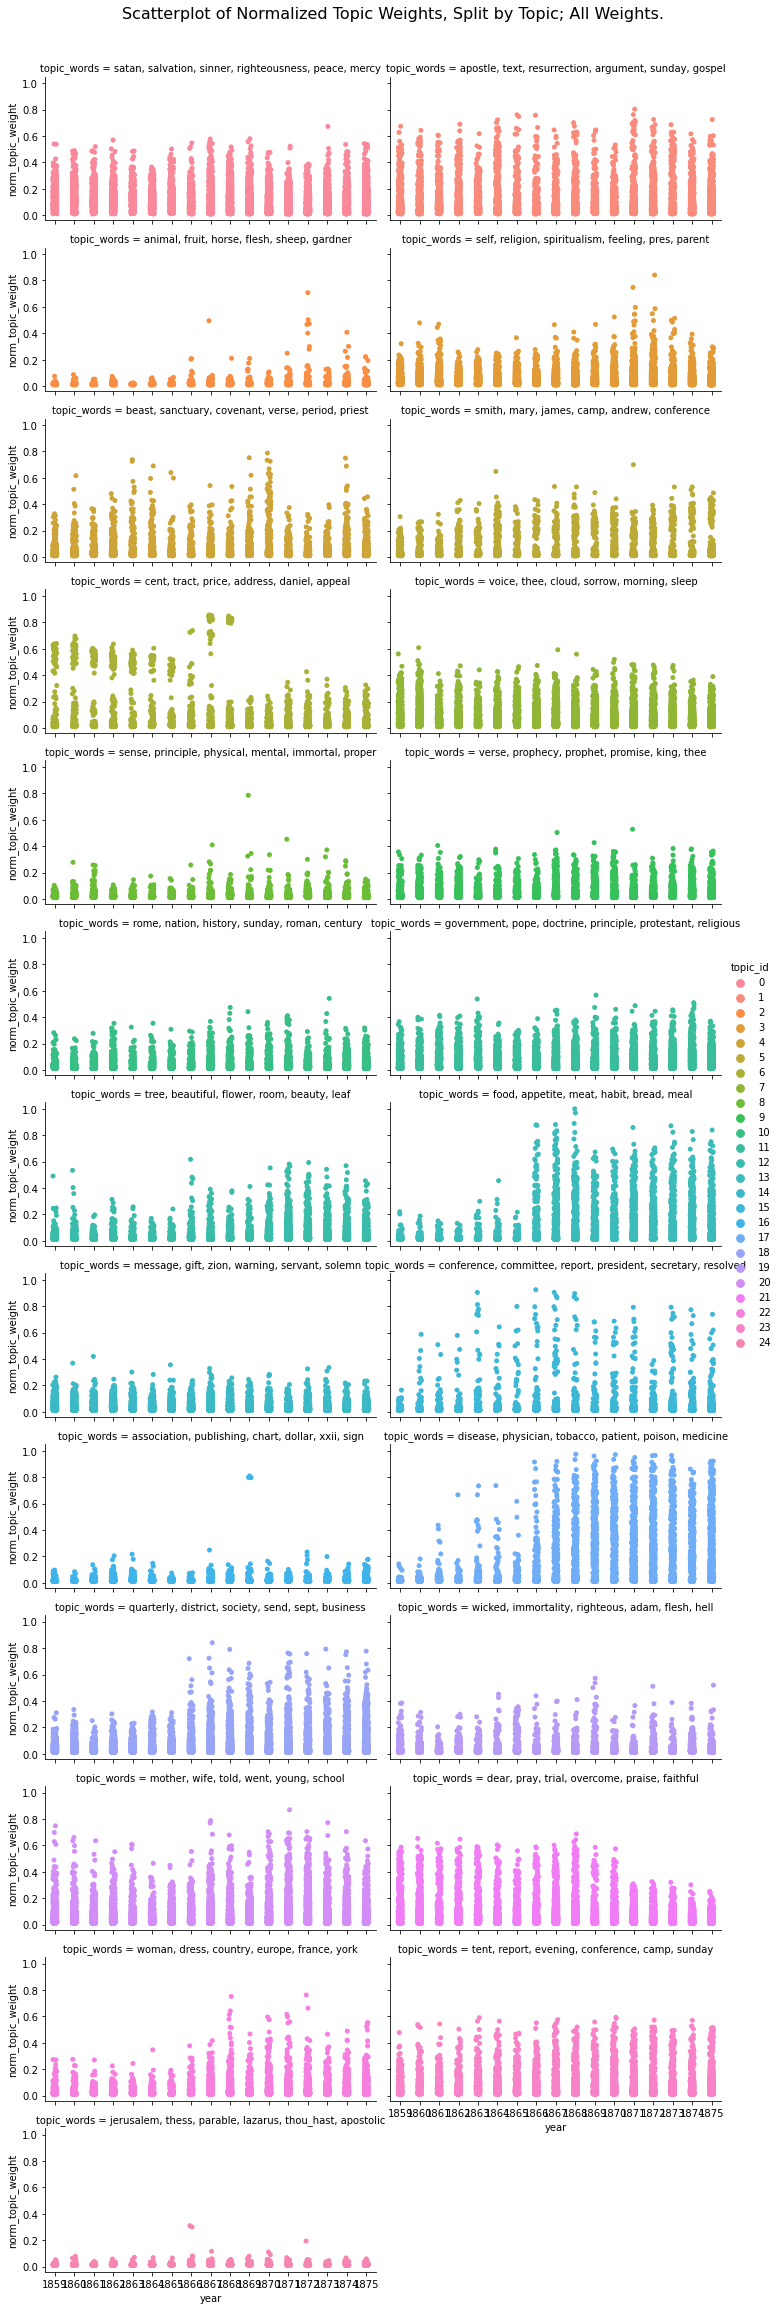

In [21]:
p = sns.factorplot(x="year", y='norm_topic_weight', hue="topic_id", col='topic_words', col_wrap=2, 
                   kind='strip', size=2.5, aspect=2, jitter=1, data=df_sum)
p.fig.subplots_adjust(top=0.95)
p.fig.suptitle("Scatterplot of Normalized Topic Weights, Split by Topic; All Weights.", fontsize=16)

While fun, this is too many plots to be useful, so I will move forward with a subset of the topics. However, if you decide to experiment with the notebook, you can switch back to the full dataframe.

In [68]:
dfs = df[(df['topic_id'] >= 15) & (df['topic_id'] <=20)]

# Average of topic weights per year

The strategy for aggregating topic weights is to average the topic weights per year. 

The average topic weight is computed by adding all of the weights for a given topic in a time period and dividing by the total number of documents in that time period. This gives us the average weight of the topic over all documents in the corpus. 

We can use the aggregation functions in Seaborn, a Python graphing library, to get a quick overview of the average topic weight by year. By default, the pointplot and bar plot functions use the mean to compute the "[central tendency and confidence interval](http://seaborn.pydata.org/tutorial/categorical.html)" of categorical data. For more control of the calculation, we can also compute the averages externally.

In [19]:
order = list(labels['topic_words'][(labels['topic_id'] >= 15) & (labels['topic_id'] <=20)])
order

['conference, committee, report, president, secretary, resolved',
 'association, publishing, chart, dollar, xxii, sign',
 'disease, physician, tobacco, patient, poison, medicine',
 'quarterly, district, society, send, sept, business',
 'wicked, immortality, righteous, adam, flesh, hell',
 'mother, wife, told, went, young, school']

In [20]:
def create_pointplot(df, y_value, hue=None, order=order, col=None, wrap=None, size=5, aspect=1.5, title=""):
    p = sns.factorplot(x="year", y=y_value, kind='point', hue_order=order, hue=hue, 
                       col=col, col_wrap=wrap, col_order=order, size=size, aspect=aspect, data=df)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    return p

In [21]:
def create_bar(df, y_value, hue=None, order=order, col=None, wrap=None, size=5, aspect=1.5, title=""):
    p = sns.factorplot(x="year", y=y_value, kind='bar', hue_order=order, hue=hue, 
                       col=col, col_wrap=wrap, col_order=order, size=size, aspect=aspect, data=df)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    return p

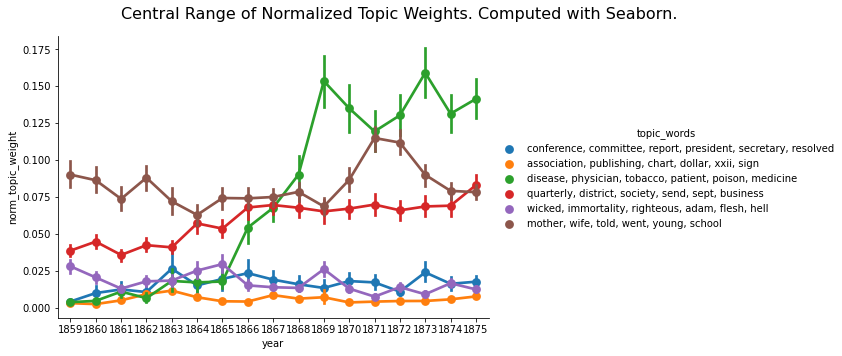

In [22]:
create_pointplot(dfs, 'norm_topic_weight', hue='topic_words', order=order, size=5, aspect=1.5,
                 title="Central Range of Normalized Topic Weights. Computed with Seaborn.")

One of the common visualizations is to show each plot separately through a facet grid. While this helps us to isolate the contours of each individual topic, it is harder to track the relationship between the topics. 

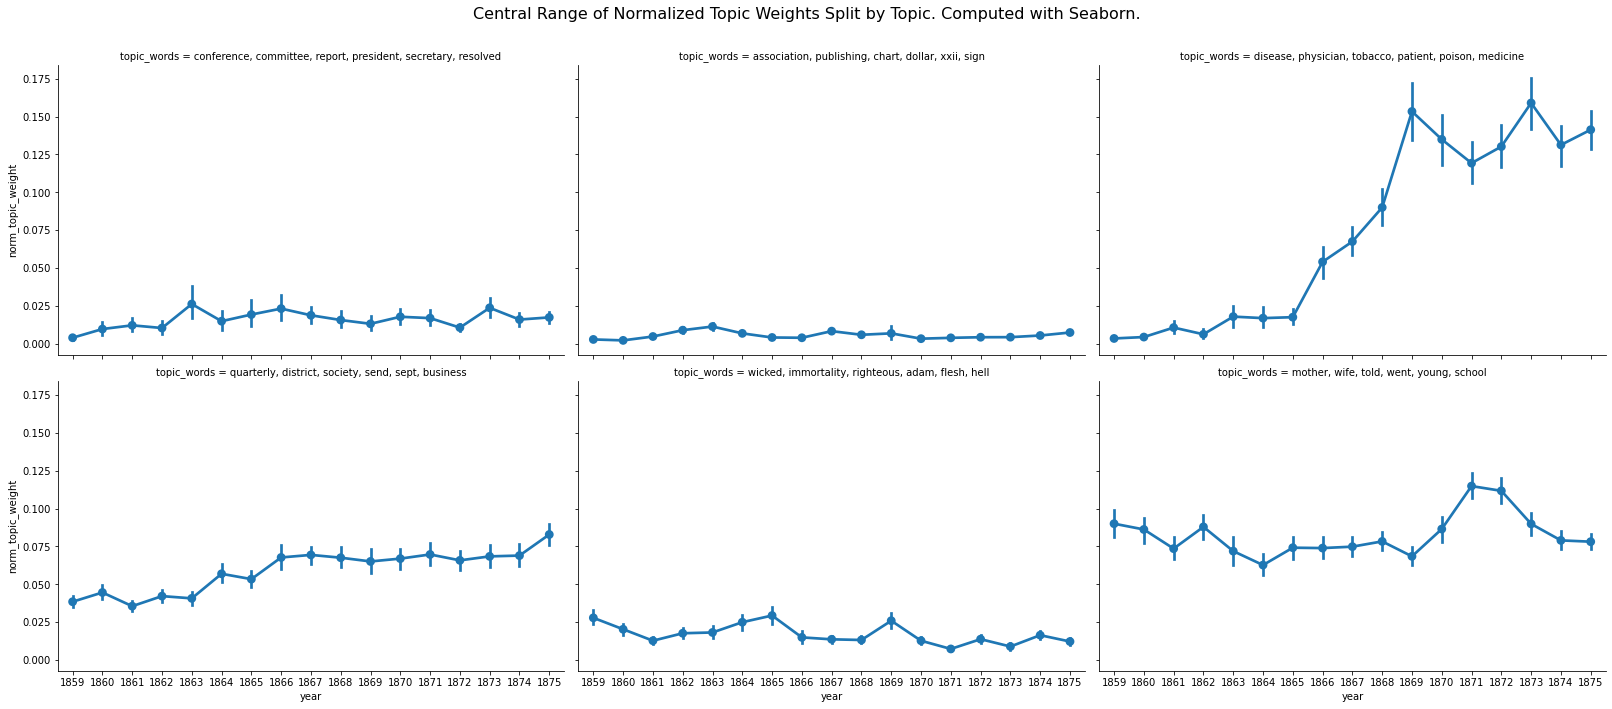

In [23]:
create_pointplot(dfs, 'norm_topic_weight', col='topic_words', wrap=3, 
                 title="Central Range of Normalized Topic Weights Split by Topic. Computed with Seaborn.")

We can also compute the average weight manually.

In [24]:
# Get number of docs per year
total_docs = df.groupby('year')['doc_id'].apply(lambda x: len(x.unique())).reset_index()
total_docs.columns = ['year', 'total_docs']

# Group by year and topic id
df_avg = df.groupby(['year', 'topic_id']).agg({'norm_topic_weight': 'sum'}).reset_index()

# Merge dataframes
df_avg = df_avg.merge(total_docs, on="year", how="left")

# Compute the mean per topic
df_avg['average_weight'] = df_avg['norm_topic_weight'] / df_avg['total_docs']

# Merge the dataframes
df_avg = df_avg.merge(labels, on='topic_id')

# Limit to sample
dfs_avg = df_avg[(df_avg['topic_id'] >=15 ) & (df_avg['topic_id']<= 20)]

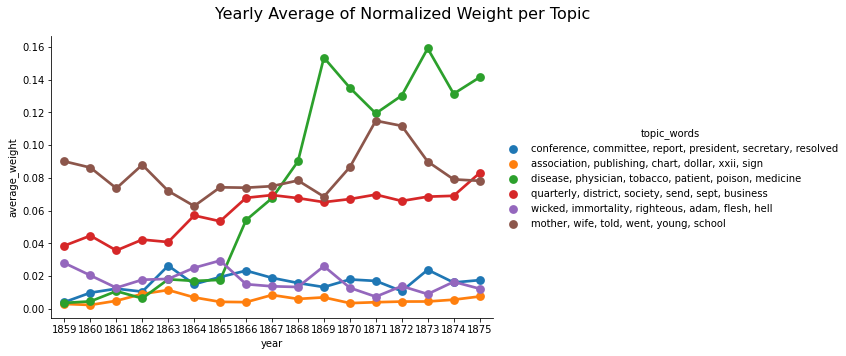

In [28]:
create_pointplot(dfs_avg, 'average_weight', hue="topic_words",
                title="Yearly Average of Normalized Weight per Topic")

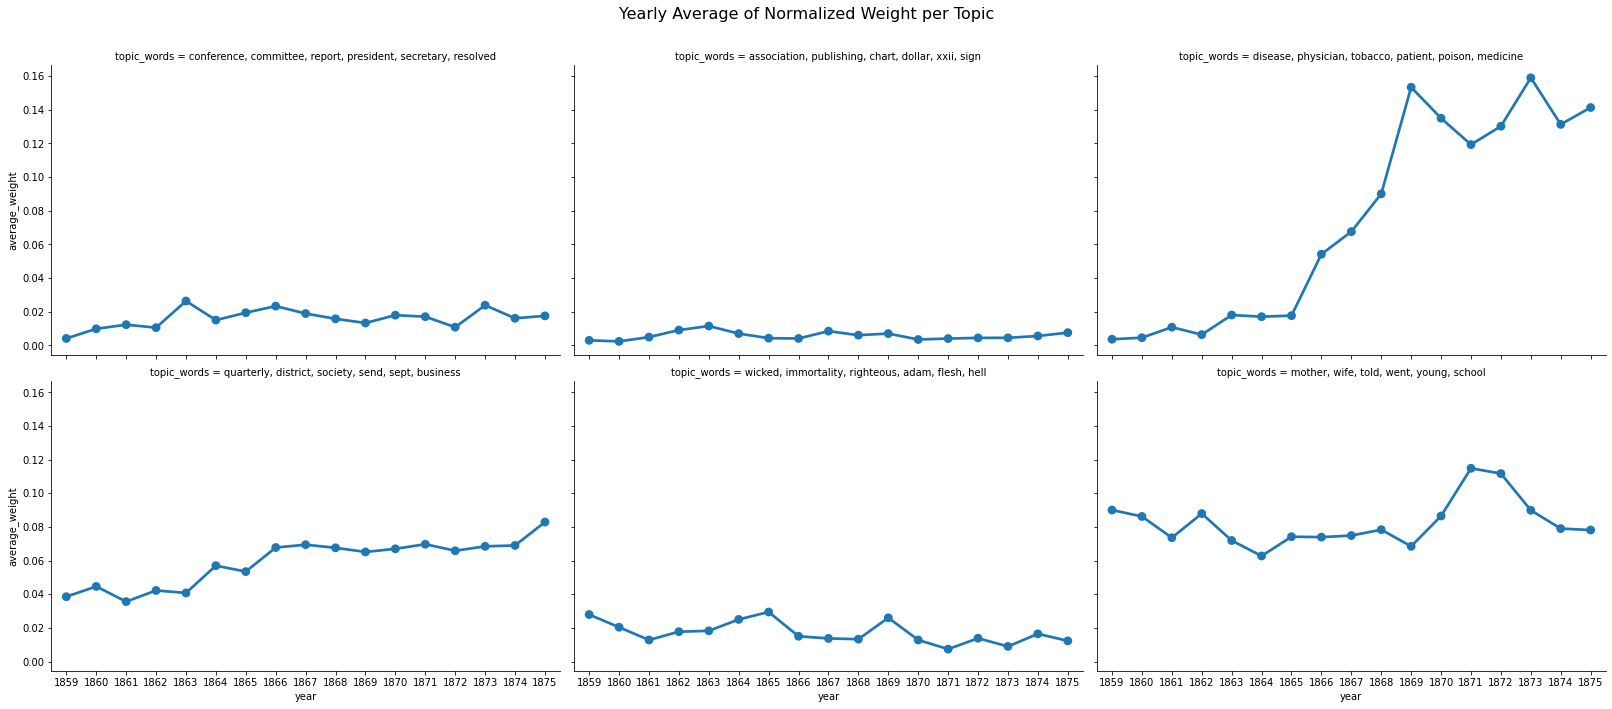

In [25]:
create_pointplot(dfs_avg, 'average_weight', col="topic_words", wrap=3,
                title="Yearly Average of Normalized Weight per Topic")

We can also display the averages as a bar chart, which encourages us to think about each year as discrete.

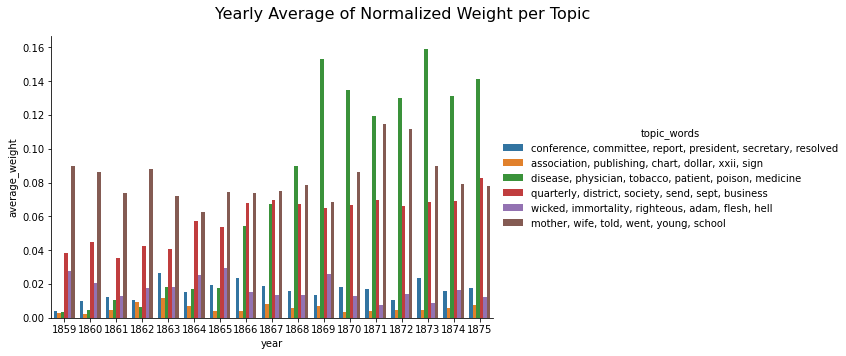

In [26]:
create_bar(dfs_avg, 'average_weight', order=order, hue="topic_words",
          title="Yearly Average of Normalized Weight per Topic")

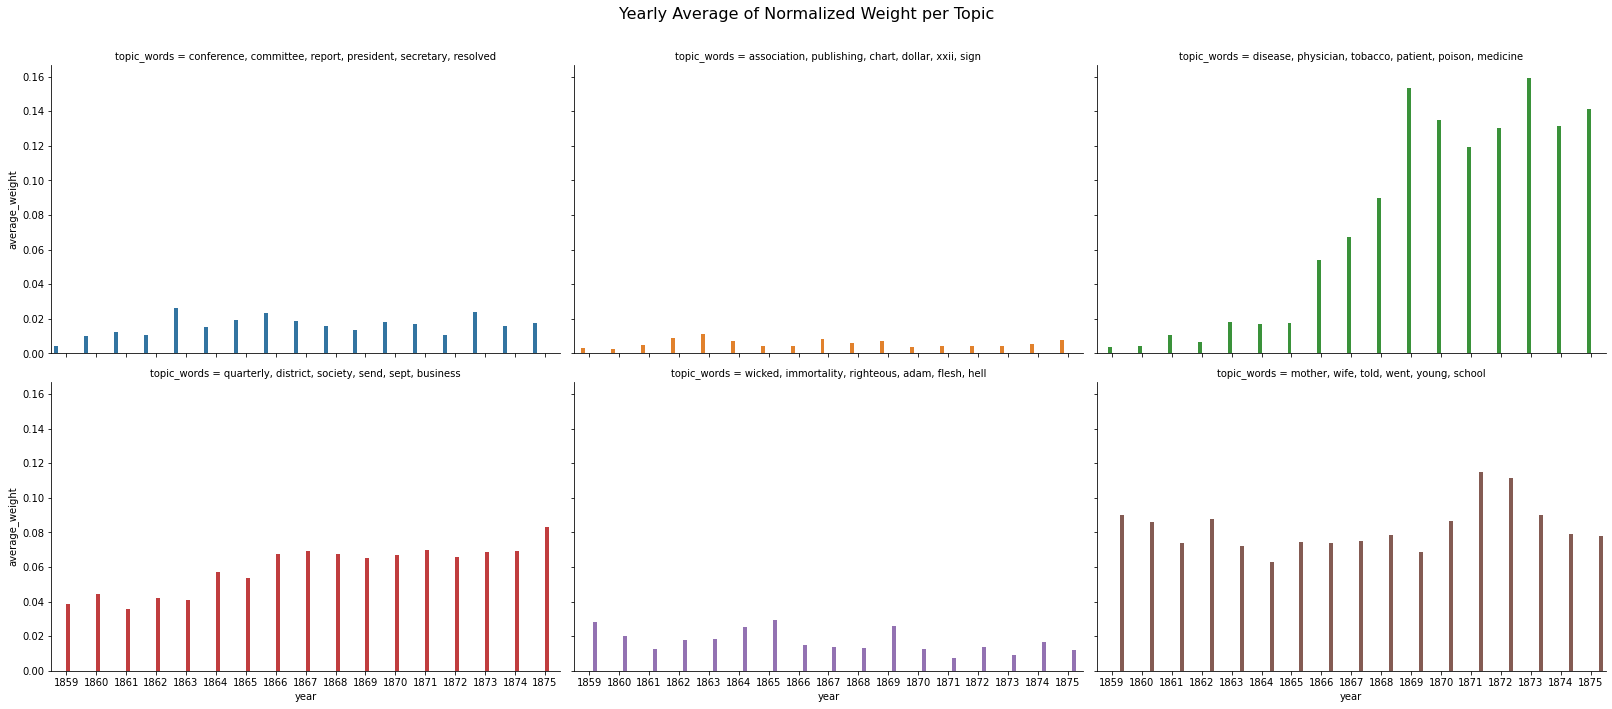

In [27]:
create_bar(dfs_avg, 'average_weight', order=order, hue="topic_words", col='topic_words',wrap=3,
          title="Yearly Average of Normalized Weight per Topic")

As a sanity check, we can show the importance of the 0 values by excluding those lines from the dataframe and using Seaborn to compute the average topic weight per year.

In [28]:
df_filtered = dfs[dfs['norm_topic_weight'] > 0]

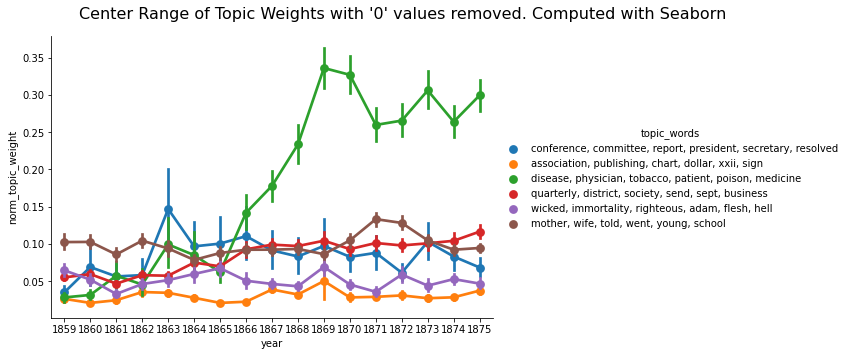

In [29]:
create_pointplot(df_filtered, 'norm_topic_weight', hue='topic_words',
                title="Center Range of Topic Weights with '0' values removed. Computed with Seaborn")

If we were to rely on this graph, we would likely postulate that the discourse of the denomination became overwhelmingly inflected with discussions of health starting in 1868. And we would likely fail to appreciate the ways that business and domestic concerns followed similar contours and were nearly as prevalent in the overall literature of the time.

### Exercise

In this exercise, please finish the following tasks.

1.For topics whose ids ranges from 0 to 5, use line and bar charts to visualize the average topic weights in integrated and isolated forms , respectively. 

2.Show the value of 0 values.

In [45]:
dfs = df[(df['topic_id'] >= 0) & (df['topic_id'] <=5)]

In [46]:
order = list(labels['topic_words'][(labels['topic_id'] >= 0) & (labels['topic_id'] <= 5)])
order

['satan, salvation, sinner, righteousness, peace, mercy',
 'apostle, text, resurrection, argument, sunday, gospel',
 'animal, fruit, horse, flesh, sheep, gardner',
 'self, religion, spiritualism, feeling, pres, parent',
 'beast, sanctuary, covenant, verse, period, priest',
 'smith, mary, james, camp, andrew, conference']

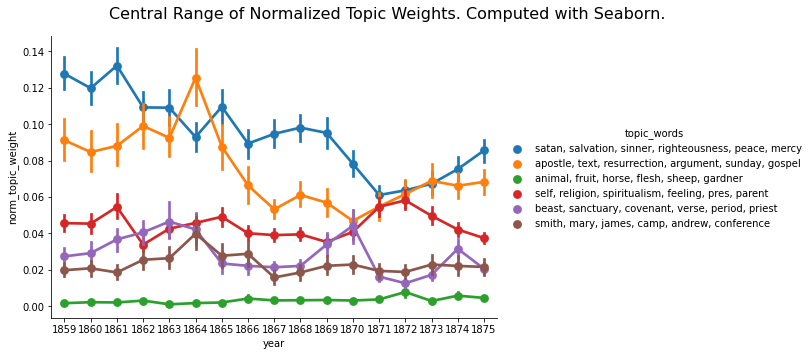

In [47]:
create_pointplot(dfs, 'norm_topic_weight', hue='topic_words', order=order, size=5, aspect=1.5,
                 title="Central Range of Normalized Topic Weights. Computed with Seaborn.")

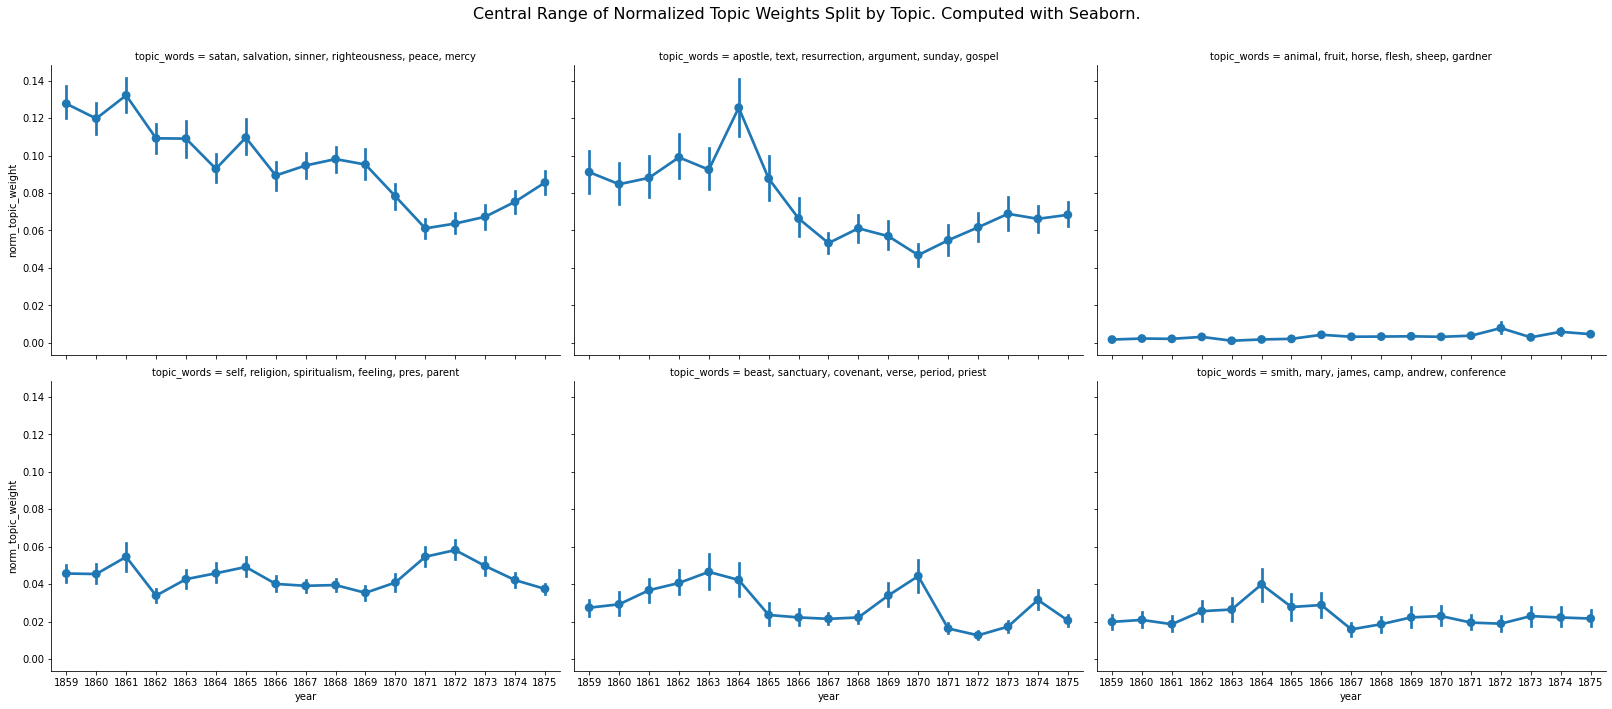

In [49]:
create_pointplot(dfs, 'norm_topic_weight', col='topic_words', order=order, wrap=3, 
                 title="Central Range of Normalized Topic Weights Split by Topic. Computed with Seaborn.")

In [50]:
# Get number of docs per year
total_docs = df.groupby('year')['doc_id'].apply(lambda x: len(x.unique())).reset_index()
total_docs.columns = ['year', 'total_docs']

# Group by year and topic id
df_avg = df.groupby(['year', 'topic_id']).agg({'norm_topic_weight': 'sum'}).reset_index()

# Merge dataframes
df_avg = df_avg.merge(total_docs, on="year", how="left")

# Compute the mean per topic
df_avg['average_weight'] = df_avg['norm_topic_weight'] / df_avg['total_docs']

# Merge the dataframes
df_avg = df_avg.merge(labels, on='topic_id')

# Limit to sample
dfs_avg = df_avg[(df_avg['topic_id'] >=0 ) & (df_avg['topic_id']<= 5)]

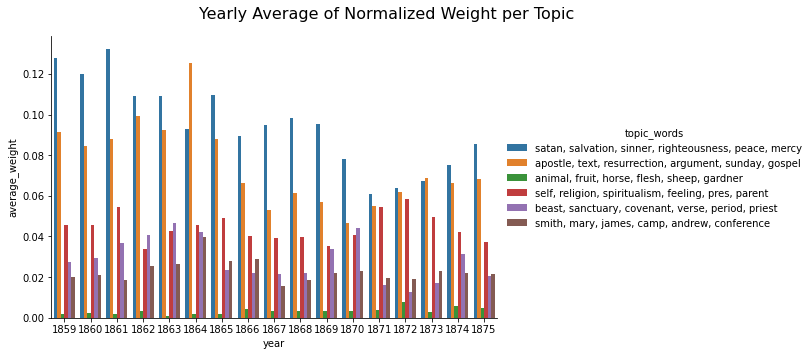

In [51]:
create_bar(dfs_avg, 'average_weight', order=order, hue="topic_words",
          title="Yearly Average of Normalized Weight per Topic")

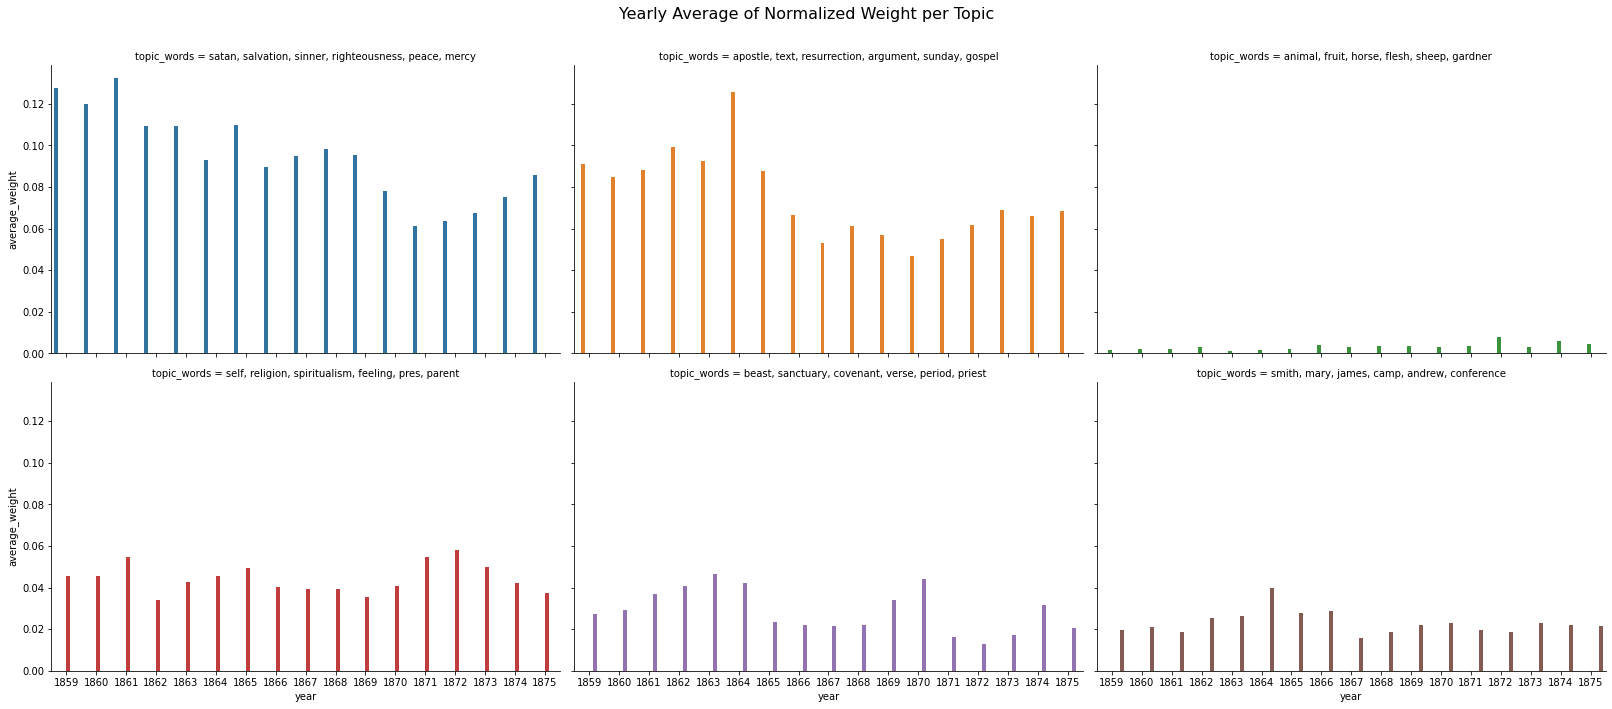

In [52]:
create_bar(dfs_avg, 'average_weight', order=order, hue="topic_words", col='topic_words',wrap=3,
          title="Yearly Average of Normalized Weight per Topic")

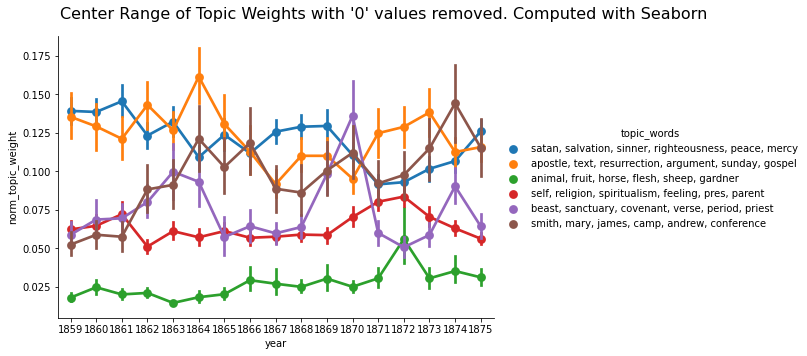

In [54]:
df_filtered = dfs[dfs['norm_topic_weight'] > 0]
create_pointplot(df_filtered, 'norm_topic_weight', hue='topic_words', order=order,
                title="Center Range of Topic Weights with '0' values removed. Computed with Seaborn")

If we rely on this graph, we are likely to infer that the weight of the topic of names has been rising since 1868. And in fact the topic about names actually maintains a steady lower level.